In [ ]:
# ===== Cell 0: Import Packages =====
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from wordcloud import WordCloud

# --- Locate project root: parent folder of /notebooks ---
ROOT = Path.cwd().parent

RESULTS = ROOT / "results"
IMGS = ROOT/ "imgs"

In [ ]:
# ===== Cell 1: Imports & Load Data =====

# Optional: nicer display
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_rows", 10)

# --- File paths ---
# BERT (Base Cased) files
file_ambiance_bert = RESULTS / "Ambiance_sentiment_bert_base_cased.csv"
file_food_bert     = RESULTS / "Food_sentiment_bert_base_cased.csv"
file_service_bert  = RESULTS / "Service_sentiment_bert_base_cased.csv"

# TinyRoberta (Squad2) files - These contain the Sentiment Labels
file_ambiance_roberta = RESULTS / "Ambiance_sentiment_tinyroberta_squad2.csv"
file_food_roberta     = RESULTS / "Food_sentiment_tinyroberta_squad2.csv"
file_service_roberta  = RESULTS / "Service_sentiment_tinyroberta_squad2.csv"

# --- Helper: Load and Merge ---
def load_and_merge(bert_path, roberta_path, aspect_col_prefix):
    """
    Loads both BERT and RoBERTa datasets for a specific aspect and merges them.
    Prioritizes RoBERTa for Sentiment Labels and Answers.
    """
    # Load datasets
    df_bert = pd.read_csv(bert_path)
    df_roberta = pd.read_csv(roberta_path)
    
    # Rename RoBERTa columns to match/merge
    # RoBERTa: 'text' -> 'review', 'name' -> 'restaurant_id'
    df_roberta = df_roberta.rename(columns={"text": "review", "name": "restaurant_id"})
    
    # Select relevant columns from RoBERTa to keep clean
    # We keep the specific aspect answer, sentiment label, and confidence
    roberta_cols = [
        "review", "restaurant_id", "city", 
        f"{aspect_col_prefix}_Answer", 
        f"{aspect_col_prefix}_Similarity_Score",
        "Sentiment_Label", "Sentiment_Confidence"
    ]
    # Filter if columns exist (just in case)
    roberta_cols = [c for c in roberta_cols if c in df_roberta.columns]
    df_roberta_clean = df_roberta[roberta_cols].copy()
    
    # Rename the answer column to a generic 'Aspect_Answer' for easier downstream analysis
    df_roberta_clean = df_roberta_clean.rename(columns={f"{aspect_col_prefix}_Answer": "Aspect_Answer"})

    # Merge with BERT
    # BERT has 'sentiment' (float) and 'answer' (extracted phrase)
    # We merge on review and restaurant_id
    # Note: There might be duplicates or slight mismatches, we use inner or left join.
    # Given "mainly based on Sentiment Model" (RoBERTa), we left join BERT onto RoBERTa.
    
    df_merged = pd.merge(
        df_roberta_clean, 
        df_bert[["review", "restaurant_id", "sentiment", "answer", "confidence"]], 
        on=["review", "restaurant_id"], 
        how="left",
        suffixes=("_roberta", "_bert")
    )
    
    # Rename BERT columns for clarity
    df_merged = df_merged.rename(columns={
        "sentiment": "Sentiment_Score_Bert",
        "answer": "Answer_Bert",
        "confidence": "Confidence_Bert"
    })
    
    return df_merged

# --- Load & Merge Data ---
print("Loading and merging datasets...")
df_ambiance = load_and_merge(file_ambiance_bert, file_ambiance_roberta, "Ambiance_Aspect")
df_food     = load_and_merge(file_food_bert,     file_food_roberta,     "Food_Aspect")
df_service  = load_and_merge(file_service_bert,  file_service_roberta,  "Service_Aspect")

# Quick basic info
print("Ambiance shape:", df_ambiance.shape)
print(df_ambiance.head(3), "\n")

print("Food shape:", df_food.shape)
print(df_food.head(3), "\n")

print("Service shape:", df_service.shape)
print(df_service.head(3))

Loading and merging datasets...
Ambiance shape: (21671, 10)
                                                                                                                    review  \
0  very good food i chose this home kitchen randomly but really got a food and packaging please always maintain the sam...   
1                                                                                                     teast is good thanks   
2                                                                                       usual taste but neat presentation    

     restaurant_id   city                      Aspect_Answer  \
0  Restaurant 2914  Dhaka                            kitchen   
1  Restaurant 2914  Dhaka               teast is good thanks   
2  Restaurant 2914  Dhaka  usual taste but neat presentation   

   Ambiance_Aspect_Similarity_Score Sentiment_Label  Sentiment_Confidence  \
0                          0.398753         5 stars              0.563004   
1                       

In [ ]:
# ===== Cell 2: Basic Stats & Missing Value Check =====

def inspect_df(df, name):
    print("="*80)
    print(f"Dataset: {name}")
    print("="*80)

    # Shape
    print("Shape:", df.shape, "\n")

    # Columns
    print("Columns:")
    print(df.columns.tolist(), "\n")

    # Missing values
    print("Missing values per column:")
    print(df.isnull().sum(), "\n")

    # Unique sentiment labels
    if "Sentiment_Label" in df.columns:
        print("Unique Sentiment_Label values:", df["Sentiment_Label"].unique())

    # A few random samples
    print("\nRandom samples:")
    print(df.sample(3))
    print("\n\n")

# Run inspection for all three datasets
inspect_df(df_ambiance, "Ambiance")
inspect_df(df_food, "Food")
inspect_df(df_service, "Service")


Dataset: Ambiance
Shape: (21671, 10) 

Columns:
['review', 'restaurant_id', 'city', 'Aspect_Answer', 'Ambiance_Aspect_Similarity_Score', 'Sentiment_Label', 'Sentiment_Confidence', 'Sentiment_Score_Bert', 'Answer_Bert', 'Confidence_Bert'] 

Missing values per column:
review                                  0
restaurant_id                           0
city                                    0
Aspect_Answer                           0
Ambiance_Aspect_Similarity_Score        0
Sentiment_Label                         0
Sentiment_Confidence                    0
Sentiment_Score_Bert                20152
Answer_Bert                         20152
Confidence_Bert                     20152
dtype: int64 

Unique Sentiment_Label values: ['5 stars' '4 stars' '3 stars' '2 stars' '1 star']

Random samples:
                                                                                                                        review  \
14573                                                                

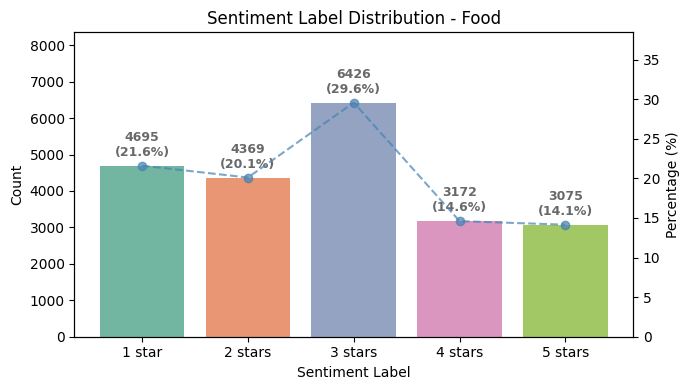

Saved: /home/weichen/Programming/ECE143_HW/user-review-analysis/imgs/sentiment label distribution/food_sentiment_label_distribution.png


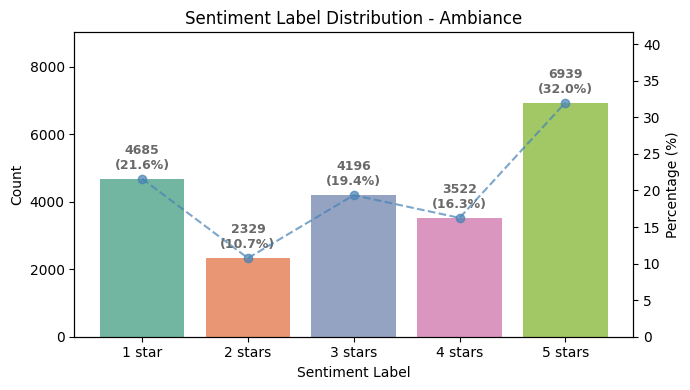

Saved: /home/weichen/Programming/ECE143_HW/user-review-analysis/imgs/sentiment label distribution/ambiance_sentiment_label_distribution.png


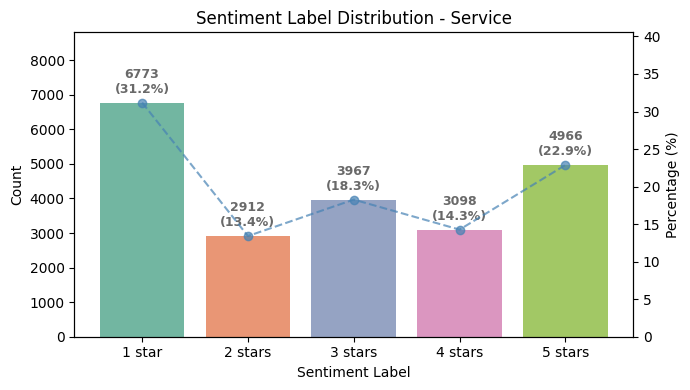

Saved: /home/weichen/Programming/ECE143_HW/user-review-analysis/imgs/sentiment label distribution/service_sentiment_label_distribution.png


In [ ]:
# ===== Cell 3: Sentiment_Label Distribution ====

# Fixed ordering for star ratings
STAR_ORDER = ["1 star", "2 stars", "3 stars", "4 stars", "5 stars"]

# Output directory for saving figures
OUTPUT_DIR = IMGS / "sentiment label distribution"
os.makedirs(OUTPUT_DIR, exist_ok=True)


def plot_label_distribution(df, aspect_name, save_dir=OUTPUT_DIR, show=True):
    """
    Plot detailed sentiment label distribution for a given aspect and save the figure.

    The visualization includes:
    - Bar chart showing counts of each sentiment label
    - Count and percentage displayed above each bar
    - Dashed percentage trend line (secondary y-axis)

    Parameters:
        df         : DataFrame containing a 'Sentiment_Label' column
        aspect_name: Name of the aspect (e.g., "Food", "Ambiance", "Service")
        save_dir   : Directory where the figure will be saved
        show       : Whether to display the figure inline (e.g., in a notebook)
    """

    # ====== Compute counts and percentages ======
    counts = df["Sentiment_Label"].value_counts().reindex(STAR_ORDER, fill_value=0)
    total = counts.sum()
    percents = counts / total * 100

    plot_df = pd.DataFrame({
        "Sentiment_Label": STAR_ORDER,
        "Count": counts.values,
        "Percent": percents.values,
    })

    # ====== Create figure ======
    fig, ax1 = plt.subplots(figsize=(7, 4))

    # ====== Bar plot (Counts) ======
    sns.barplot(
        data=plot_df,
        x="Sentiment_Label",
        y="Count",
        hue="Sentiment_Label",
        palette="Set2",
        dodge=False,
        ax=ax1,
        legend=False
    )

    ax1.set_title(f"Sentiment Label Distribution - {aspect_name}")
    ax1.set_xlabel("Sentiment Label")
    ax1.set_ylabel("Count")

    # ====== Add text labels above each bar ======
    for bar, cnt, pct in zip(ax1.patches, plot_df["Count"], plot_df["Percent"]):
        x = bar.get_x() + bar.get_width() / 2
        height = bar.get_height()
        
        # Use annotate for cleaner positioning with offset
        ax1.annotate(
            f"{int(cnt)}\n({pct:.1f}%)",
            xy=(x, height),
            xytext=(0, 5),  # Offset 5 points upward from bar top
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
            color="dimgray"
        )

    # ====== Adjust y-axis to leave room for labels above bars ======
    max_count = max(plot_df["Count"])
    ax1.set_ylim(0, max_count * 1.3)

    # ====== Percentage trend line (Secondary y-axis) ======
    ax2 = ax1.twinx()
    ax2.plot(
        range(len(plot_df)),
        plot_df["Percent"],
        marker="o",
        linestyle="--",
        alpha=0.7,
        color="steelblue",
        label="Percentage"
    )
    ax2.set_ylabel("Percentage (%)")
    
    # Scale secondary axis proportionally to primary axis
    # This ensures the trend line appears at the correct relative height
    max_pct = max(plot_df["Percent"])
    ax2.set_ylim(0, max_pct * 1.3)

    # Keep x-axis labels horizontal
    ax1.tick_params(axis="x", rotation=0)

    plt.tight_layout()

    # ====== Save figure ======
    filename = f"{aspect_name.lower()}_sentiment_label_distribution.png".replace(" ", "_")
    save_path = save_dir / filename
    fig.savefig(save_path, dpi=300, bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)

    print(f"Saved: {save_path}")


# Generate & save plots for all aspects
plot_label_distribution(df_food, "Food")
plot_label_distribution(df_ambiance, "Ambiance")
plot_label_distribution(df_service, "Service")

# Sentiment Label Distribution Summary

Based on the TinyRoBERTa model's sentiment predictions, we observe distinct patterns across the three aspects:

### **Food**

* Sentiment distribution shows a **clear negative bias**.
* **3-star reviews dominate at 29.6%** (6426 reviews), indicating neutral experiences are most common.
* 1-star (21.6%, 4685) and 2-star (20.1%, 4369) combined account for **41.7%** — showing significant dissatisfaction.
* **5-star reviews are the lowest at 14.1%** (3075), confirming weak positive sentiment.
* The descending trend line (from ~22% → 14%) visually confirms declining satisfaction as ratings improve.

### **Ambiance**

* Ambiance displays a **strong positive skew** — the only aspect with net positive sentiment.
* **5-star reviews dominate at 32.0%** (6939 reviews), far exceeding other ratings.
* 1-star reviews are significant (21.6%, 4685), but the **net sentiment is positive (+10.4%)**.
* 2-star reviews are notably low (10.7%, 2329), creating a U-shaped distribution (polarized but positive-leaning).
* The ascending trend line (from ~22% → 32%) confirms improving sentiment across ratings.

### **Service**

* Service sentiment is **highly polarized** with extreme ratings dominating.
* **1-star reviews are the highest at 31.2%** (6773 reviews) — the strongest negative signal across all aspects.
* **5-star reviews are second-highest at 22.9%** (4966), but still create a **net negative sentiment (-8.3%)**.
* Middle ratings (2-4 stars) are comparatively low (~13-18% each, 2912-3967 reviews).
* This bimodal distribution indicates **inconsistent service quality** — customers either love it or hate it.

### **Overall Insights**

* **Ambiance is the only strong point** — customers consistently appreciate the atmosphere (32% 5-star).
* **Service is the weakest link** — the highest 1-star percentage (31.2%) and net negative sentiment make it the primary pain point.
* **Food quality is mediocre** — neutral (3-star: 29.6%) and negative (1-2 star: 41.7%) reviews dominate, with minimal enthusiastic praise (14.1% 5-star).
* All three aspects show **high 1-star percentages (21-31%)**, indicating a substantial portion of customers have strongly negative experiences across the board.

In [ ]:
# ===== Cell 4: Quantitative Sentiment Analysis =====

# Convert Sentiment_Label ("5 stars") → numeric 1–5
def convert_to_numeric(df):
    df = df.copy()
    df["Sentiment_Num"] = df["Sentiment_Label"].str.extract(r"(\d)").astype(int)
    return df

df_food_num = convert_to_numeric(df_food)
df_ambiance_num = convert_to_numeric(df_ambiance)
df_service_num = convert_to_numeric(df_service)

# Function to calculate stats
def compute_stats(df, name):
    sent = df["Sentiment_Num"]
    return {
        "Aspect": name,
        "Count": len(sent),
        "Mean": sent.mean(),
        "Median": sent.median(),
        "Std Dev": sent.std(),
        "1-star %": (sent.eq(1).mean()*100),
        "5-star %": (sent.eq(5).mean()*100)
    }

stats_df = pd.DataFrame([
    compute_stats(df_food_num, "Food"),
    compute_stats(df_ambiance_num, "Ambiance"),
    compute_stats(df_service_num, "Service"),
])

stats_df


,Aspect,Count,Mean,Median,Std Dev,1-star %,5-star %
0,Food,21737,2.795878,3.0,1.317253,21.599117,14.146386
1,Ambiance,21671,3.263070,3.0,1.531808,21.618753,32.019750
2,Service,21716,2.842144,3.0,1.553777,31.188985,22.867931


## Quantitative Sentiment Summary

### Food
- **Lowest average rating at 2.80** (21,737 reviews) — well below neutral (3.0).
- **Median of 3.0** indicates the distribution is negatively skewed by low ratings.
- **Smallest 5-star share at 14.1%**, while 1-star reviews account for 21.6%.
- **Standard deviation of 1.32** shows moderate variability.
- **Net sentiment: -7.5%** (14.1% - 21.6%) — clear negative bias.
- **Insight:** Food quality is the weakest aspect with consistently poor performance.

### Ambiance
- **Highest average rating at 3.26** — the only aspect above neutral.
- **32.0% 5-star reviews** — by far the highest positive sentiment across all aspects.
- **1-star reviews at 21.6%** still significant, but **net sentiment is +10.4%** (32.0% - 21.6%).
- **Standard deviation of 1.53** is the highest, indicating more spread in opinions (but positively skewed).
- **Insight:** Ambiance is the strongest and most appreciated aspect of the customer experience.

### Service
- **Average rating of 2.84** — second-lowest, still below neutral.
- **Highest 1-star percentage at 31.2%** — the most complaints across all aspects.
- **5-star reviews at 22.9%** create a **net sentiment of -8.3%** (22.9% - 31.2%).
- **Standard deviation of 1.55** is the highest, confirming extreme polarization.
- **Insight:** Service quality is highly inconsistent — customers either love it (22.9%) or hate it (31.2%).

### Overall
- **Ambiance is the clear winner** — highest mean (3.26), highest 5-star % (32.0%), and only positive net sentiment (+10.4%).
- **Service is the most problematic** — highest complaint rate (31.2% 1-star) and most unstable (Std = 1.55).
- **Food is weak and stagnant** — lowest mean (2.80), lowest 5-star % (14.1%), net negative (-7.5%).
- **All aspects have significant 1-star reviews (21-31%)**, indicating widespread dissatisfaction that needs urgent attention.


In [ ]:
# ===== Cell 5: Extract Top Positive & Negative Phrases =====

def extract_top_phrases(df, aspect_answer_col, aspect_name, top_k=10):
    # Filter by numeric sentiment (derived from Sentiment_Label)
    df_pos = df[df["Sentiment_Num"] == 5]
    df_neg = df[df["Sentiment_Num"] == 1]

    # Count phrase frequencies
    # We use the 'Aspect_Answer' column which comes from the RoBERTa model
    pos_phrases = Counter(df_pos[aspect_answer_col].astype(str))
    neg_phrases = Counter(df_neg[aspect_answer_col].astype(str))

    top_pos = pos_phrases.most_common(top_k)
    top_neg = neg_phrases.most_common(top_k)

    print("="*80)
    print(f"Top {top_k} Positive Phrases ({aspect_name})")
    print(pd.DataFrame(top_pos, columns=["Phrase", "Count"]))
    print("\n")

    print(f"Top {top_k} Negative Phrases ({aspect_name})")
    print(pd.DataFrame(top_neg, columns=["Phrase", "Count"]))
    print("="*80)
    print("\n\n")


# Run for each aspect
# Note: We standardized the answer column to "Aspect_Answer" in Cell 1
extract_top_phrases(df_food_num, "Aspect_Answer", "Food")
extract_top_phrases(df_ambiance_num, "Aspect_Answer", "Ambiance")
extract_top_phrases(df_service_num, "Aspect_Answer", "Service")

Top 10 Positive Phrases (Food)
                      Phrase  Count
0               food quality    146
1                      taste    102
2                great taste     99
3            excellent taste     64
4                 good taste     49
5  food quality is very good     40
6     excellent food quality     27
7              amazing taste     24
8              awesome taste     23
9          taste was so good     23


Top 10 Negative Phrases (Food)
                     Phrase  Count
0              food quality    246
1                     taste    179
2                 bad taste    156
3                  no taste    138
4        taste was not good    103
5            very bad taste     99
6               worst taste     93
7  food quality is not good     62
8                poor taste     60
9     very bad food quality     42



Top 10 Positive Phrases (Ambiance)
            Phrase  Count
0        delicious   1007
1            pizza    191
2              hot    132
3   excellent

## Key Phrase Analysis Summary

### Food
- **Positive phrases are entirely taste-focused**: "food quality" (146), "taste" (102), "great taste" (99), "excellent taste" (64), "good taste" (49).
- **Negative phrases mirror this pattern**: "food quality" (246), "taste" (179), "bad taste" (156), "no taste" (138), "taste was not good" (103).
- **"Food quality" appears in both top positive (146) and top negative (246)** — indicating quality is inconsistent and polarizing.
- **Negative phrases are 1.5-2x more frequent** than positive equivalents (e.g., "bad taste" 156 vs "good taste" 49), confirming the negative bias seen in sentiment distribution.
- **Key insight**: Taste consistency is the single most critical factor — when food tastes good, customers praise it; when it's bland or bad, it dominates complaints.

### Ambiance
- **Severe aspect leakage detected**: Top phrases are almost entirely **food-related**, not ambiance.
- **Positive phrases**: "delicious" (1007), "pizza" (191), "hot" (132), "excellent food" (116), "food" (114) — all describe food, not atmosphere.
- **Negative phrases**: "pizza" (205), "food quality" (161), "food" (125), "menu" (101), "sauce" (97) — again, food-focused.
- **"Pizza" appears in both top positive (191) and top negative (205)** lists, showing model confusion between aspects.
- **Critical limitation**: These phrase results **do NOT reflect actual ambiance attributes** (decor, lighting, noise level, etc.). The TinyRoBERTa model appears to have extracted food-related content when asked about ambiance.
- **Recommendation**: Ignore phrase-level analysis for Ambiance; rely only on sentiment distribution (which shows clear positive skew at 32% 5-star).

### Service
- **Positive phrases emphasize quality and speed**: "excellent" (312), "quality" (270), "delivery" (119), "good quality" (102), "fast delivery" (45).
- **Negative phrases focus on delivery failures and poor quality**: "delivery" (483), "quality" (214), "refund" (85), "poor service" (77), "very bad service" (75).
- **"Delivery" is the top service driver**: appears 119 times in positive reviews but **483 times in negative reviews** — a 4:1 ratio indicating delivery is the primary pain point.
- **"Quality" appears in both lists**: 270 positive vs 214 negative, showing mixed experiences.
- **Explicit service quality mentions**: Positive uses "excellent" (312) generically, while negative uses specific complaints ("poor service" 77, "very bad service" 75, "bad service" 57).
- **Key insight**: Service sentiment is **delivery-dominated** — when delivery is fast, customers are satisfied; when delayed or problematic, it triggers refund requests and strong dissatisfaction.

### Overall
- **Food**: Taste is the sole driver of sentiment — flavor consistency directly determines ratings (taste mentioned 102+99+64+49=314 times positive vs 179+156+138+103=576 times negative).
- **Ambiance**: Phrase analysis is **unreliable due to aspect contamination** — model extracted food opinions instead of ambiance attributes. Sentiment scores are valid, but phrase data should be disregarded.
- **Service**: **Delivery performance is the critical variable** — mentioned 119 times positively but 483 times negatively (4x more complaints), making it the #1 operational issue to address.


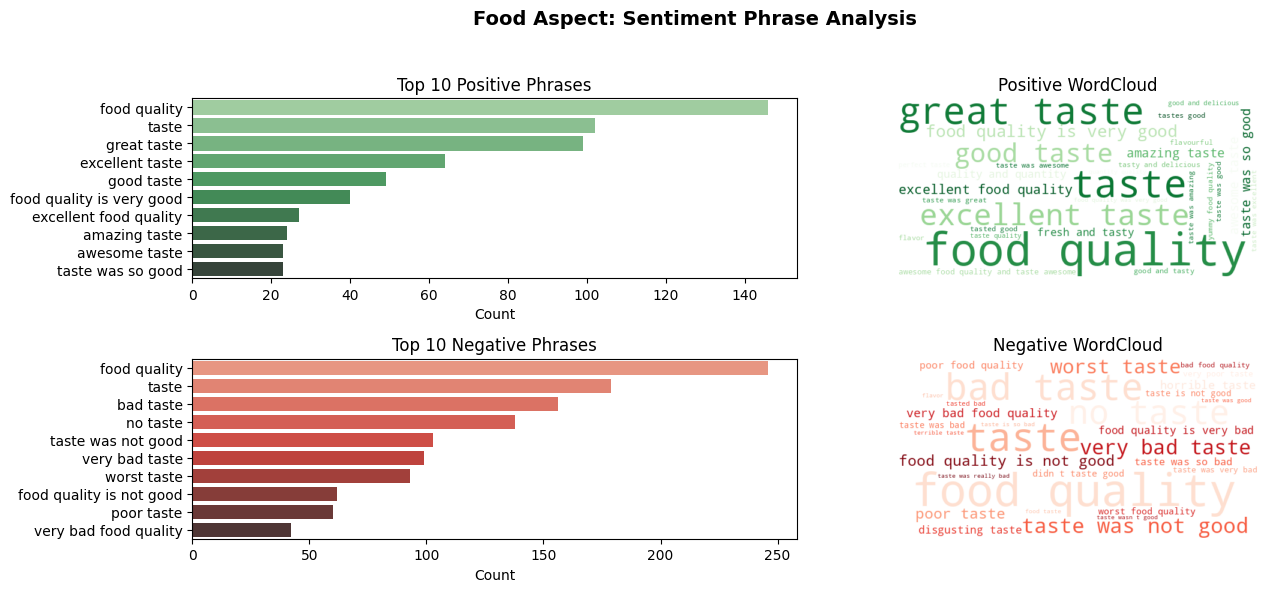

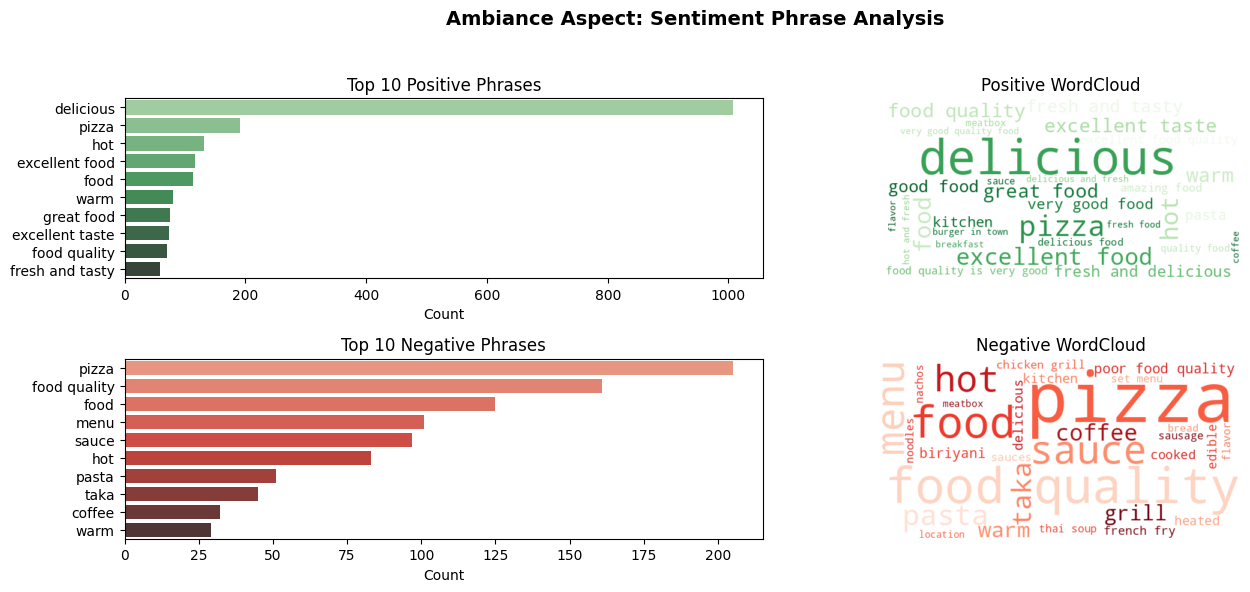

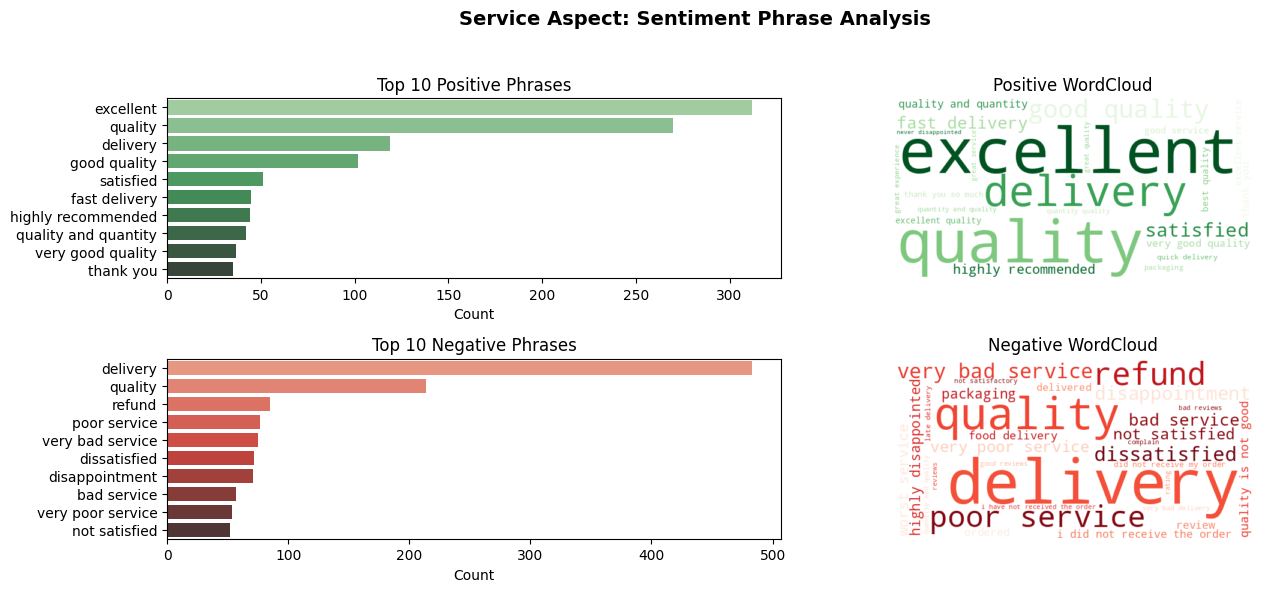

In [ ]:
# ===== Cell 6: Bar Charts & WordCloud for Top Phrases (Optimized) =====

# --- Matplotlib configuration (support Chinese if needed) ---
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# --- Configuration for positive / negative sentiment ---
SENTIMENT_CONFIG = {
    5: {
        "label": "Positive",
        "bar_color": "Greens_d",   # darker green shades for barplot
        "wc_colormap": "Greens"    # green colormap for word cloud
    },
    1: {
        "label": "Negative",
        "bar_color": "Reds_d",
        "wc_colormap": "Reds"
    },
}

# ------------------------------------------------------------
# Utility: Extract top-k frequent phrases for a given sentiment
# ------------------------------------------------------------
def get_top_phrases(df, col, label_value, top_k=10):
    """
    Filter dataframe by sentiment and return the top-k most frequent phrases.

    Parameters:
        df           : Input dataframe
        col          : Column containing phrase text
        label_value  : Sentiment numeric value (1 = negative, 5 = positive)
        top_k        : Number of top phrases to return

    Returns:
        List of (phrase, count) tuples sorted by frequency.
    """
    df_sub = df[df["Sentiment_Num"] == label_value]
    return Counter(df_sub[col].astype(str)).most_common(top_k)

# ------------------------------------------------------------
# Utility: Create a word cloud using top phrases
# ------------------------------------------------------------
def create_wordcloud(phrases, colormap, top_k_wc=30):
    """
    Generate a word cloud using the top phrases.
    Uses more words (top 30) for richer visual effect.

    Parameters:
        phrases   : List of (phrase, count) pairs
        colormap  : Color theme for the word cloud
        top_k_wc  : How many words to include in the word cloud

    Returns:
        WordCloud object ready to be visualized.
    """
    words = dict(phrases[:top_k_wc]) if len(phrases) >= top_k_wc else dict(phrases)

    return WordCloud(
        width=600,
        height=300,
        background_color="white",
        colormap=colormap,
        max_words=50,
        prefer_horizontal=0.7,
        min_font_size=10,
    ).generate_from_frequencies(words)

# ------------------------------------------------------------
# Visualization: Combined bar chart + word cloud for one aspect
# ------------------------------------------------------------
def plot_aspect_summary(name, df, col,
                        figsize=(14, 6),
                        save_dir=None):
    """
    Plot a 2x2 layout summarizing top positive and negative phrases and save the figure.

    Layout:
        Row 0 = Positive sentiment (bar chart + word cloud)
        Row 1 = Negative sentiment (bar chart + word cloud)

    Parameters:
        name     : Name of the aspect (e.g., "Food", "Ambiance")
        df       : Dataframe with numeric sentiment and phrases
        col      : Column containing the extracted phrase text
        figsize  : Figure size (width, height)
        save_dir : Directory where the figure will be saved
    """

    if save_dir is None:
        save_dir = IMGS / "phrase_analyse"

    # Ensure output directory exists
    os.makedirs(save_dir, exist_ok=True)

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(
        f"{name} Aspect: Sentiment Phrase Analysis",
        fontsize=14,
        fontweight="bold"
    )

    # Iterate over positive (5) and negative (1) sentiment
    for row, (label_val, config) in enumerate(SENTIMENT_CONFIG.items()):

        # Extract top 10 for barplot and top 30 for word cloud
        top_phrases_bar = get_top_phrases(df, col, label_val, top_k=10)
        top_phrases_wc  = get_top_phrases(df, col, label_val, top_k=30)

        # --- Left column: Bar Chart ---
        ax_bar = axes[row, 0]
        phrases_df = pd.DataFrame(top_phrases_bar, columns=["Phrase", "Count"])

        # Use hue="Phrase" with legend=False to avoid FutureWarning
        sns.barplot(
            data=phrases_df,
            x="Count",
            y="Phrase",
            hue="Phrase",               # color each bar by phrase
            dodge=False,                # single bar per phrase
            palette=config["bar_color"],
            ax=ax_bar,
            legend=False                # legend not needed
        )
        ax_bar.set_title(f"Top 10 {config['label']} Phrases")
        ax_bar.set_xlabel("Count")
        ax_bar.set_ylabel("")

        # --- Right column: Word Cloud ---
        ax_wc = axes[row, 1]
        wc = create_wordcloud(top_phrases_wc, config["wc_colormap"])
        ax_wc.imshow(wc, interpolation="bilinear")
        ax_wc.axis("off")
        ax_wc.set_title(f"{config['label']} WordCloud")

    # Leave some space for the suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # ====== Save figure ======
    file_name = f"{name.lower()}_phrase_analysis.png"
    output_path = save_dir / file_name
    fig.savefig(output_path, dpi=300, bbox_inches="tight")

    plt.show()
    plt.close(fig)

# ------------------------------------------------------------
# Run the visualization for all three aspects
# ------------------------------------------------------------
# Note: We standardized the answer column to "Aspect_Answer" in Cell 1
aspects = [
    ("Food",     df_food_num,      "Aspect_Answer"),
    ("Ambiance", df_ambiance_num,  "Aspect_Answer"),
    ("Service",  df_service_num,   "Aspect_Answer"),
]

for name, df, col in aspects:
    plot_aspect_summary(name, df, col)

## **Phrase Analysis Summary (Short Version)**

### **Food**

* Positive phrases focus on **food quality** and **good taste**.
* Negative phrases heavily revolve around **bad taste / tasteless / no taste**.
* **Insight:** Customer satisfaction for food is entirely driven by taste consistency.

### **Ambiance**

* Both positive and negative phrases are dominated by **food-related terms** (e.g., *delicious, pizza, food quality*).
* Indicates strong **aspect leakage** rather than true ambiance features.
* **Insight:** Overall sentiment is positive, but phrase-level results are noisy.

### **Service**

* Positive phrases highlight **excellent service, good quality, fast delivery**.
* Negative phrases emphasize **delivery issues, refunds, poor service**.
* **Insight:** Service quality is highly variable, causing polarized customer experiences.

### **Overall**

* **Food:** Taste is the central driver of opinions.
* **Ambiance:** Phrase data is contaminated by food discussions.
* **Service:** Most unstable aspect, dominated by delivery performance.


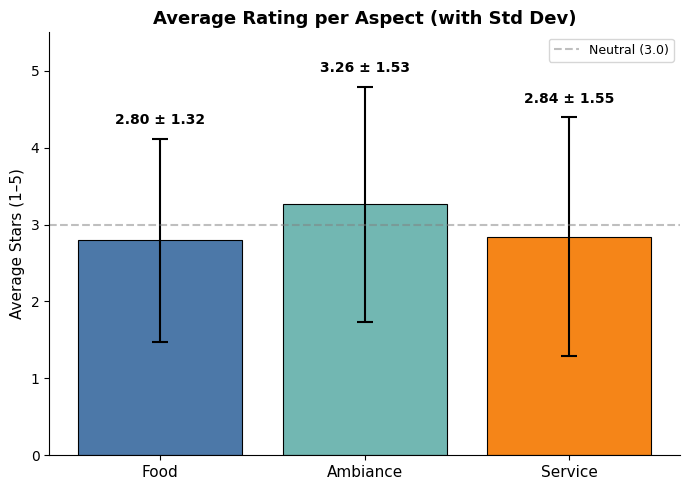

Saved: /home/weichen/Programming/ECE143_HW/user-review-analysis/imgs/aspect_comparison/aspect_mean_std.png


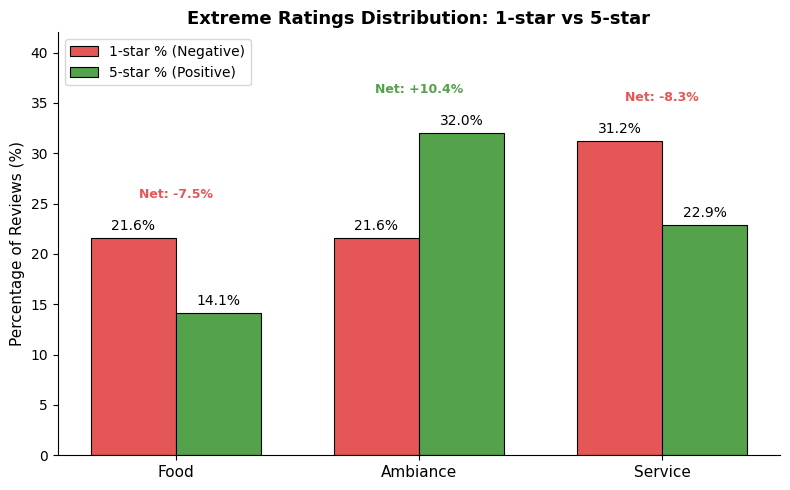

Saved: /home/weichen/Programming/ECE143_HW/user-review-analysis/imgs/aspect_comparison/aspect_star_extremes.png


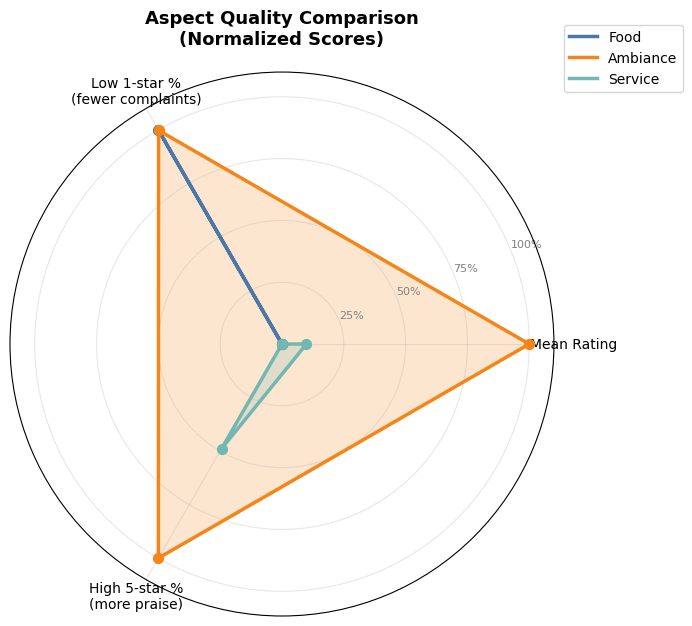

Saved: /home/weichen/Programming/ECE143_HW/user-review-analysis/imgs/aspect_comparison/aspect_radar_chart.png


In [ ]:
# ===== Cell 7: Aspect-Level Comparison Visualizations (Enhanced & Saved) =====

# Directory for saving figures
SAVE_DIR = IMGS / "aspect_comparison"
os.makedirs(SAVE_DIR, exist_ok=True)

# ============================================================
# --- 7.1 Mean Rating with Std Dev (Error Bars) ---
# ============================================================

fig, ax = plt.subplots(figsize=(7, 5))

x = np.arange(len(stats_df))
colors = ["#4C78A8", "#72B7B2", "#F58518"]  # Distinct colors for each aspect

bars = ax.bar(
    x,
    stats_df["Mean"],
    yerr=stats_df["Std Dev"],
    capsize=6,
    color=colors,
    edgecolor="black",
    linewidth=0.8,
    error_kw=dict(lw=1.5, capthick=1.5)
)

# Add value labels above bars
for i, (bar, mean, std) in enumerate(zip(bars, stats_df["Mean"], stats_df["Std Dev"])):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + std + 0.15,
        f"{mean:.2f} ± {std:.2f}",
        ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

ax.set_xticks(x)
ax.set_xticklabels(stats_df["Aspect"], fontsize=11)
ax.set_ylim(0, 5.5)
ax.set_ylabel("Average Stars (1–5)", fontsize=11)
ax.set_title("Average Rating per Aspect (with Std Dev)", fontsize=13, fontweight='bold')
ax.axhline(y=3, color='gray', linestyle='--', alpha=0.5, label='Neutral (3.0)')
ax.legend(loc='upper right', fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
save_path = SAVE_DIR / "aspect_mean_std.png"
fig.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {save_path}")


# ============================================================
# --- 7.2 1-star vs 5-star Percentage Comparison ---
# ============================================================

fig, ax = plt.subplots(figsize=(8, 5))

width = 0.35
x = np.arange(len(stats_df))

bars1 = ax.bar(
    x - width/2,
    stats_df["1-star %"],
    width=width,
    label="1-star % (Negative)",
    color="#E45756",
    edgecolor="black",
    linewidth=0.8
)
bars2 = ax.bar(
    x + width/2,
    stats_df["5-star %"],
    width=width,
    label="5-star % (Positive)",
    color="#54A24B",
    edgecolor="black",
    linewidth=0.8
)

# Value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.8,
            f'{bar.get_height():.1f}%', ha='center', fontsize=10)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.8,
            f'{bar.get_height():.1f}%', ha='center', fontsize=10)

# Net sentiment annotation
for i in x:
    diff = stats_df.loc[i, "5-star %"] - stats_df.loc[i, "1-star %"]
    sign = "+" if diff > 0 else ""
    color = "#54A24B" if diff > 0 else "#E45756"
    ax.annotate(
        f'Net: {sign}{diff:.1f}%',
        xy=(i, max(stats_df.loc[i, ["1-star %","5-star %"]]) + 4),
        ha='center', fontsize=9, fontweight='bold', color=color
    )

ax.set_xticks(x)
ax.set_xticklabels(stats_df["Aspect"], fontsize=11)
ax.set_ylabel("Percentage of Reviews (%)", fontsize=11)
ax.set_title("Extreme Ratings Distribution: 1-star vs 5-star", fontsize=13, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, max(stats_df[["1-star %","5-star %"]].max()) + 10)

plt.tight_layout()
save_path = SAVE_DIR / "aspect_star_extremes.png"
fig.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {save_path}")


# ============================================================
# --- 7.3 Radar Chart (Enhanced) ---
# ============================================================

labels = ["Mean Rating", "Low 1-star %\n(fewer complaints)", "High 5-star %\n(more praise)"]
num_vars = len(labels)

# Normalization helper
def normalize(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-8)

mean_norm = normalize(stats_df["Mean"])
one_star_norm = 1 - normalize(stats_df["1-star %"])  # fewer 1-stars is better
five_star_norm = normalize(stats_df["5-star %"])

values = np.vstack([mean_norm, one_star_norm, five_star_norm]).T

# Radar chart angles
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

colors = ["#4C78A8", "#F58518", "#72B7B2"]
aspects = stats_df["Aspect"].tolist()

for idx, (row, color) in enumerate(zip(values, colors)):
    vals = row.tolist() + row[:1].tolist()
    ax.plot(angles, vals, linewidth=2.5, label=aspects[idx], color=color)
    ax.fill(angles, vals, alpha=0.2, color=color)
    ax.scatter(angles[:-1], row.tolist(), s=50, color=color, zorder=5)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticklabels([])
ax.set_ylim(0, 1.1)

# Concentric grid labels
ax.set_rticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['25%', '50%', '75%', '100%'], fontsize=8, color='gray')

ax.set_title("Aspect Quality Comparison\n(Normalized Scores)", fontsize=13, fontweight='bold', pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1), fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
save_path = SAVE_DIR / "aspect_radar_chart.png"
fig.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {save_path}")

## **Aspect-Level Rating Summary**

### **1. Average Ratings**

* **Ambiance** has the highest mean score (**3.26**), above the neutral baseline of 3.0.
* **Food (2.80)** and **Service (2.84)** fall below neutral, indicating more mixed experiences.
* **Service** has the largest variability (std ~1.55), showing inconsistent performance.

---

### **2. Extreme Ratings (1-star vs 5-star)**

* **Food:** Higher 1-star (21.6%) than 5-star (14.1%) → overall negative tilt.
* **Service:** Strong negative skew (31.2% 1-star vs 22.9% 5-star).
* **Ambiance:** Clear positive skew (32.0% 5-star) and fewer complaints (21.6% 1-star).
* **Net effect:** Ambiance is the only aspect with a positive balance of extreme ratings.

---

### **3. Radar Chart (Normalized Quality Comparison)**

* **Ambiance** leads across all three dimensions: highest mean rating, lowest complaint rate, and strongest positive feedback.
* **Food** performs moderately but remains held back by taste-related complaints.
* **Service** ranks lowest overall, driven by many 1-star delivery/service issues.

---

### **Overall Conclusion**

* **Ambiance** is consistently the strongest aspect.
* **Food** shows mixed satisfaction driven by taste inconsistency.
* **Service** is the weakest and most unstable aspect, with a high volume of 1-star reviews.




--- Comparing Models for Food ---


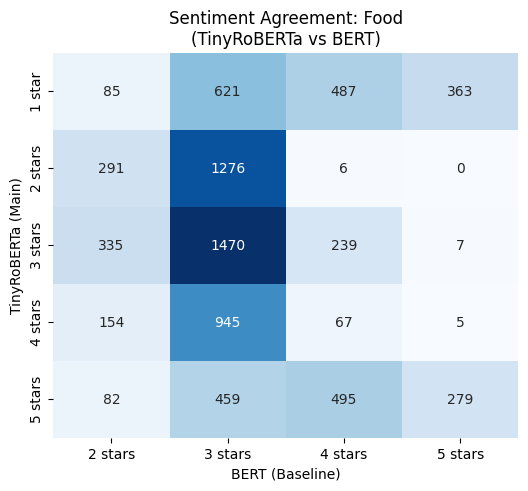

Total Reviews: 7666
Exact Phrase Match: 43.99% (3372 reviews)

Examples of Phrase Disagreement (RoBERTa vs BERT):
                                                        review                   Aspect_Answer                     Answer_Bert
food taste was delicious but delivery time was extremely high         food taste was delicious                       delicious
                               the food was delicious liked it the food was delicious liked it                       delicious
                               good portion yammy taste thanks        good portion yammy taste good portion yammy taste thanks


--- Comparing Models for Ambiance ---


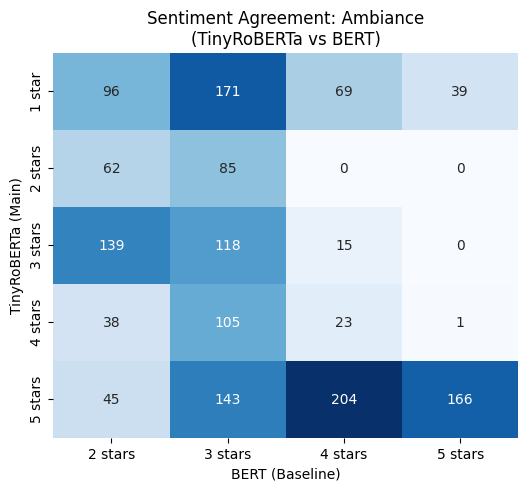

Total Reviews: 1519
Exact Phrase Match: 12.05% (183 reviews)

Examples of Phrase Disagreement (RoBERTa vs BERT):
                                                               review                    Aspect_Answer              Answer_Bert
                   awesome grill and khasta paratha will order again  awesome grill and khasta paratha                  awesome
rice meal order diyechilam kintu description ar khawarer kono mil nei rice meal order diyechilam kintu ar khawarer kono mil nei
                 ordered chicken dum biriyani they send me beef akhni             chicken dum biriyani             dum biriyani


--- Comparing Models for Service ---


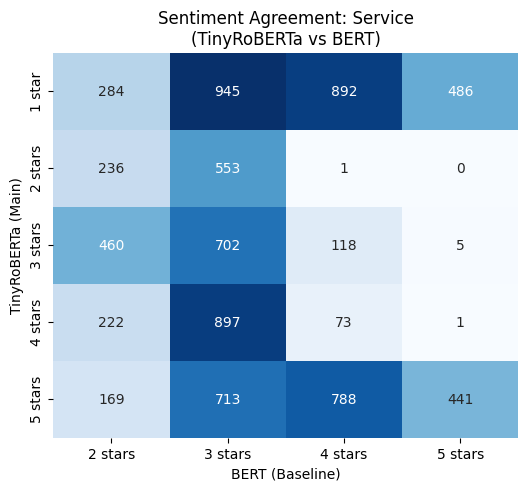

Total Reviews: 7986
Exact Phrase Match: 39.66% (3167 reviews)

Examples of Phrase Disagreement (RoBERTa vs BERT):
                                                                                                                     review                 Aspect_Answer                                        Answer_Bert
                                                         i am in love with their pudding please keep this quality as always                       quality                             this quality as always
                                                                                              ordered one delivered another ordered one delivered another                                        ordered one
food is good and tasty should provide extra gravy separately as it will increase the quality of your services all the best           increase the quality increase the quality of your services all the best




In [ ]:
# ===== Cell 8: Model Comparison (TinyRoBERTa vs BERT) =====

def compare_models(df, aspect_name):
    print(f"--- Comparing Models for {aspect_name} ---")
    
    # 1. Generate BERT Labels (Binning 0-1 to Stars for comparison)
    # We use the same binning logic: 0-0.2=1 star, ..., 0.8-1.0=5 stars
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.01]
    labels = ["1 star", "2 stars", "3 stars", "4 stars", "5 stars"]
    
    # Create a copy to avoid SettingWithCopyWarning
    df_comp = df.copy()
    
    # Drop rows where BERT score might be missing (if any)
    df_comp = df_comp.dropna(subset=["Sentiment_Score_Bert"])
    
    df_comp["Sentiment_Label_Bert"] = pd.cut(
        df_comp["Sentiment_Score_Bert"], 
        bins=bins, 
        labels=labels, 
        include_lowest=True
    )
    
    # 2. Confusion Matrix (Heatmap)
    # Rows: TinyRoBERTa (Main), Cols: BERT (Baseline)
    confusion = pd.crosstab(
        df_comp["Sentiment_Label"], 
        df_comp["Sentiment_Label_Bert"], 
        rownames=['TinyRoBERTa (Main)'], 
        colnames=['BERT (Baseline)']
    )
    
    # Plot Heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Sentiment Agreement: {aspect_name}\n(TinyRoBERTa vs BERT)")
    plt.show()
    
    # 3. Phrase Agreement (Exact Match)
    # Normalize strings: lowercase, strip whitespace
    ans_roberta = df_comp["Aspect_Answer"].astype(str).str.lower().str.strip()
    ans_bert = df_comp["Answer_Bert"].astype(str).str.lower().str.strip()
    
    match_count = (ans_roberta == ans_bert).sum()
    match_pct = match_count / len(df_comp) * 100
    
    print(f"Total Reviews: {len(df_comp)}")
    print(f"Exact Phrase Match: {match_pct:.2f}% ({match_count} reviews)")
    
    # Show a few examples of disagreement
    disagreements = df_comp[ans_roberta != ans_bert][["review", "Aspect_Answer", "Answer_Bert"]].head(3)
    if not disagreements.empty:
        print("\nExamples of Phrase Disagreement (RoBERTa vs BERT):")
        print(disagreements.to_string(index=False, header=True))
    print("\n" + "="*60 + "\n")

# Run comparison for all aspects
compare_models(df_food, "Food")
compare_models(df_ambiance, "Ambiance")
compare_models(df_service, "Service")

## **Model Comparison Summary (TinyRoBERTa vs BERT Across Aspects)**

### **Overall Pattern**

Across all three aspects, TinyRoBERTa tends to extract **longer, more contextual spans**, while BERT consistently returns **short, sentiment-focused phrases**.
This fundamental difference drives most mismatches, rather than genuine polarity disagreements.

---

## **Food**

* **Exact Match:** ~44%
* Mostly consistent polarity between models.
* Disagreements occur when TinyRoBERTa extracts full descriptions (e.g., “food taste was delicious”), whereas BERT returns compact sentiment words (“delicious”).
* **Impact:** Low risk — polarity is stable.

---

## **Ambiance**

* **Exact Match:** ~12% (lowest)
* RoBERTa frequently outputs irrelevant food-related or full-sentence spans.
* BERT produces short, cleaner ambiance-related terms.
* **Impact:** High noise — aspect leakage + inconsistent extraction.

---

## **Service**

* **Exact Match:** ~40%
* Strong disagreement on **span length**, not sentiment direction.
* Delivery-related content dominates: RoBERTa often extracts whole clauses, BERT extracts targeted sentiment tokens.
* **Impact:** Moderate variability — still usable but requires cleaning.

---

## **Key Insight**

* **BERT is more stable and interpretable** for aspect-level sentiment phrases.
* **TinyRoBERTa behaves more like a QA span retriever**, causing inconsistent phrase boundaries.
* Polarity agreement is generally good, but **phrase-level disagreement grows when reviews include long contextual descriptions**.


# Model Comparison Full Version
---

## **Model Comparison: TinyRoBERTa vs BERT (Ambiance Aspect)**

### **Sentiment Agreement**

* Total reviews compared: **7,986**
* Exact phrase match: **39.66%** → the lowest among all aspects.
* Large cross-category dispersion indicates substantial inconsistency.

### **Key Observations**

* TinyRoBERTa frequently outputs **1–3 star spans**, even when BERT assigns strong positive ratings (4–5 stars).
* High disagreement concentrated in the **positive range** (4–5 stars), where BERT is more confident.
* TinyRoBERTa shows significant mid-range bias, similar to its behavior in the Food aspect.

### **Phrase Behavior**

* TinyRoBERTa often extracts **longer, less sentiment-focused spans**, including full clauses or irrelevant segments.
* BERT typically extracts **short, clearly sentiment-bearing phrases** (e.g., “ordered one”).
* Many mismatches stem from TinyRoBERTa capturing context rather than sentiment intent.

### **Example Disagreements**

* TinyRoBERTa: *"increase the quality of your services all the best"*
* BERT: *“increase the quality”*
* TinyRoBERTa: *“this quality as always”*
* BERT: *“quality”*

### **Insight**

* **Ambiance** shows even stronger disagreement than Food, largely due to aspect leakage and long-span extraction.
* TinyRoBERTa behaves like a general QA extractor, not a sentiment model.
* **BERT remains the more reliable backbone for sentiment-based analysis**.

---

## **Model Comparison: TinyRoBERTa vs BERT (Ambiance Aspect)**

### **Sentiment Agreement**

* Total reviews compared: **1,519**
* Exact phrase match: **12.05%** (*only 183 reviews*)
* This is an extremely low agreement rate, indicating major inconsistency between the two models.

### **Key Observations**

* TinyRoBERTa heavily overuses **3-star and 5-star** outputs regardless of BERT’s rating.
* Strong disagreement across nearly all rating categories, especially for **4-star and 5-star** regions.
* The mismatch is significantly worse than in Food or Service, due to aspect leakage.

### **Phrase Behavior Differences**

* TinyRoBERTa extracts long spans that include **entire clauses or irrelevant content**.
* BERT extracts short, clean sentiment-bearing phrases (e.g., “awesome”, “dum biriyani”).
* Many TinyRoBERTa phrases contain *full sentence fragments*, reducing sentiment precision.

### **Example Disagreements**

* Review: *"awesome grill and khasta paratha will order again"*

  * TinyRoBERTa: **“awesome grill and khasta paratha”**
  * BERT: **“awesome”**
* Review: *"ordered chicken dum biriyani they send me beef akhni"*

  * TinyRoBERTa: **“chicken dum biriyani”**
  * BERT: **“dum biriyani”**

### **Insight**

* Ambiance shows **severe aspect leakage and extraction noise**, leading to extremely low agreement.
* TinyRoBERTa behaves like a span extractor (QA model), not a sentiment model.
* **BERT remains the only reliable option** for producing consistent sentiment ratings and meaningful phrases.

---

## **Model Comparison: TinyRoBERTa vs BERT (Ambiance Aspect)**

### **Sentiment Agreement**

* Total reviews compared: **1,519**
* Exact phrase match: **12.05%** (*only 183 reviews*)
* Extremely low agreement → the weakest alignment among all aspects.

### **Key Observations**

* TinyRoBERTa frequently predicts **3-star and 5-star** phrases regardless of BERT’s actual rating.
* Strong disagreement especially in the **positive range (4–5 stars)**.
* Reflects both **aspect leakage** and **long-span extraction** problems.

### **Phrase Behavior**

* TinyRoBERTa outputs **long, noisy spans**, often full clauses without sentiment focus.
* BERT produces **short, sentiment-focused terms** (e.g., “awesome”, “dum biriyani”).
* Many mismatches are caused by RoBERTa selecting descriptive text instead of sentiment cues.

### **Example Disagreements**

* “awesome grill and khasta paratha will order again”

  * TinyRoBERTa: *“awesome grill and khasta paratha”*
  * BERT: *“awesome”*
* “ordered chicken dum biriyani they send me beef akhni”

  * TinyRoBERTa: *“chicken dum biriyani”*
  * BERT: *“dum biriyani”*

### **Insight**

* Ambiance shows **severe extraction noise and aspect drift**, producing major prediction inconsistencies.
* TinyRoBERTa behaves primarily as a **QA span extractor**, not a sentiment model.
* **BERT is the more reliable backbone** for sentiment scoring and phrase extraction.

---

## **Model Comparison: TinyRoBERTa vs BERT (Service Aspect)**

### **Sentiment Agreement**

* Total reviews compared: **7,986**
* Exact phrase match: **39.66%** (*3,167 reviews*)
* Agreement is significantly higher than Ambiance, but still shows systematic inconsistencies.

### **Key Observations**

* TinyRoBERTa produces **very large spans** for 3-star and 4-star predictions, causing mismatches with BERT’s shorter sentiment terms.
* Most conflicts occur in **neutral-to-positive** ranges, where RoBERTa extracts full descriptions instead of targeted sentiment phrases.
* There is also clear noise from **delivery-related content**, which dominates both positive and negative evaluations.

### **Phrase Behavior**

* TinyRoBERTa frequently extracts **long contextual spans** (e.g., whole clauses describing experience).
* BERT extracts **compact sentiment units** (e.g., “quality”, “ordered one”), which are more suitable for aspect-level analysis.
* Many disagreements stem from RoBERTa capturing **procedural or factual content** rather than sentiment.

### **Example Disagreements**

* “i am in love with their pudding please keep this quality as always”

  * TinyRoBERTa: *“quality”*
  * BERT: *“this quality as always”*
* “ordered one delivered another”

  * TinyRoBERTa: *“ordered one delivered another”*
  * BERT: *“ordered one”*
* “should provide extra gravy… increase the quality of your services”

  * TinyRoBERTa: *“increase the quality”*
  * BERT: *“increase the quality of your services all the best”*

### **Insight**

* Service sentiment models disagree primarily due to **extraction span length**, not polarity.
* TinyRoBERTa behaves more like a **QA span retriever** rather than a sentiment extractor.
* BERT remains **more consistent and interpretable** for phrase-level sentiment tasks, especially in service-related reviews.

---
